In [2]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
from joblib import dump, load
import os
import requests
import datetime
import json
import yfinance as yf
%matplotlib inline
warnings.filterwarnings('ignore')

---

## S&P 500

In [3]:
tickers = ['^GSPC']

data = yf.download(tickers, '2016-01-01')
data.fillna(method='ffill', inplace=True)
data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-25,3046.600098,3086.250000,3024.010010,3083.760010,3083.760010,4815420000
2020-06-26,3073.199951,3073.729980,3004.629883,3009.050049,3009.050049,8098120000
2020-06-29,3018.590088,3053.889893,2999.739990,3053.239990,3053.239990,4462770000
2020-06-30,3050.199951,3111.510010,3047.830078,3100.290039,3100.290039,4696280000
2020-07-01,3105.919922,3128.439941,3101.169922,3115.860107,3115.860107,2697727407


In [4]:
data['Daily_Return'] = data['Close'].dropna().pct_change()
data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return
Date,,,,,,,
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000,NaN
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000,0.002012
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000,-0.013115
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000,-0.023700
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4664940000,-0.010838
...,...,...,...,...,...,...,...
2020-06-25,3046.600098,3086.250000,3024.010010,3083.760010,3083.760010,4815420000,0.010959
2020-06-26,3073.199951,3073.729980,3004.629883,3009.050049,3009.050049,8098120000,-0.024227
2020-06-29,3018.590088,3053.889893,2999.739990,3053.239990,3053.239990,4462770000,0.014686


In [5]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_close'] = data['Close'].ewm(halflife=short_window).mean()
data['slow_close'] = data['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
data['crossover_long'] = np.where(data['fast_close'] > data['slow_close'], 1.0, 0.0)
data['crossover_short'] = np.where(data['fast_close'] < data['slow_close'], -1.0, 0.0)
data['crossover_signal'] = data['crossover_long'] + data['crossover_short']

data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,,,,,,
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000,NaN,2012.660034,2012.660034,0.0,0.0,0.0
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000,0.002012,2015.359985,2014.755149,1.0,0.0,1.0
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000,-0.013115,2001.017142,2006.018067,0.0,-1.0,-1.0
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000,-0.023700,1970.122648,1988.614595,0.0,-1.0,-1.0
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4664940000,-0.010838,1945.300651,1973.390722,0.0,-1.0,-1.0


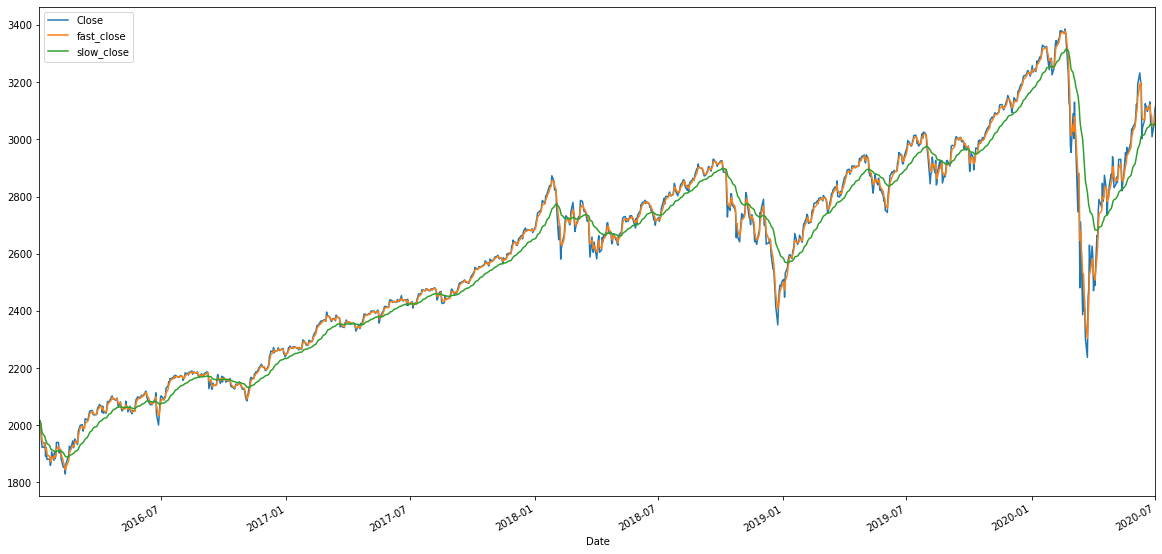

In [6]:
# Plot the EMA of BTC/USD closing prices
data[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [7]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_vol'] = data['Daily_Return'].ewm(halflife=short_vol_window).std()
data['slow_vol'] = data['Daily_Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
data['vol_trend_long'] = np.where(data['fast_vol'] < data['slow_vol'], 1.0, 0.0)
data['vol_trend_short'] = np.where(data['fast_vol'] > data['slow_vol'], -1.0, 0.0) 
data['vol_trend_signal'] = data['vol_trend_long'] + data['vol_trend_short']

data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,,,,,,
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000,NaN,2012.660034,2012.660034,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000,0.002012,2015.359985,2014.755149,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000,-0.013115,2001.017142,2006.018067,0.0,-1.0,-1.0,0.010697,0.010697,0.0,0.0,0.0
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000,-0.023700,1970.122648,1988.614595,0.0,-1.0,-1.0,0.011950,0.012866,1.0,0.0,1.0
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4664940000,-0.010838,1945.300651,1973.390722,0.0,-1.0,-1.0,0.008741,0.010343,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,3046.600098,3086.250000,3024.010010,3083.760010,3083.760010,4815420000,0.010959,3084.736870,3053.172709,1.0,0.0,1.0,0.018841,0.018387,0.0,-1.0,-1.0
2020-06-26,3073.199951,3073.729980,3004.629883,3009.050049,3009.050049,8098120000,-0.024227,3046.893459,3050.217946,0.0,-1.0,-1.0,0.019866,0.018879,0.0,-1.0,-1.0
2020-06-29,3018.590088,3053.889893,2999.739990,3053.239990,3053.239990,4462770000,0.014686,3050.066725,3050.420324,0.0,-1.0,-1.0,0.021640,0.018654,0.0,-1.0,-1.0


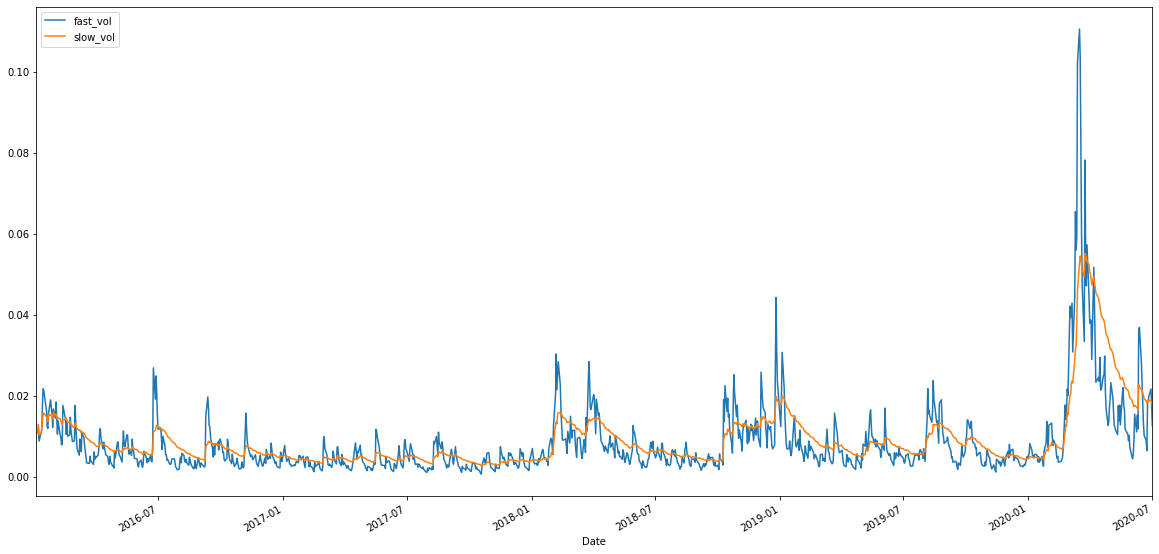

In [8]:
# Plot the EMA of BTC/USD daily return volatility
data[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

In [9]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
data['bollinger_mid_band'] = data['Close'].rolling(window=bollinger_window).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
data['bollinger_upper_band']  = data['bollinger_mid_band'] + (data['bollinger_std'] * 1)
data['bollinger_lower_band']  = data['bollinger_mid_band'] - (data['bollinger_std'] * 1)

# Calculate bollinger band trading signal
data['bollinger_long'] = np.where(data['Close'] < data['bollinger_lower_band'], 1.0, 0.0)
data['bollinger_short'] = np.where(data['Close'] > data['bollinger_upper_band'], -1.0, 0.0)
data['bollinger_signal'] = data['bollinger_long'] + data['bollinger_short']

data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000,NaN,2012.660034,2012.660034,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000,0.002012,2015.359985,2014.755149,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000,-0.013115,2001.017142,2006.018067,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000,-0.023700,1970.122648,1988.614595,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4664940000,-0.010838,1945.300651,1973.390722,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,3046.600098,3086.250000,3024.010010,3083.760010,3083.760010,4815420000,0.010959,3084.736870,3053.172709,1.0,...,0.0,-1.0,-1.0,3109.213525,60.514460,3169.727985,3048.699065,0.0,0.0,0.0
2020-06-26,3073.199951,3073.729980,3004.629883,3009.050049,3009.050049,8098120000,-0.024227,3046.893459,3050.217946,0.0,...,0.0,-1.0,-1.0,3107.450525,62.968704,3170.419229,3044.481821,1.0,0.0,1.0
2020-06-29,3018.590088,3053.889893,2999.739990,3053.239990,3053.239990,4462770000,0.014686,3050.066725,3050.420324,0.0,...,0.0,-1.0,-1.0,3107.326025,63.078712,3170.404737,3044.247314,0.0,0.0,0.0


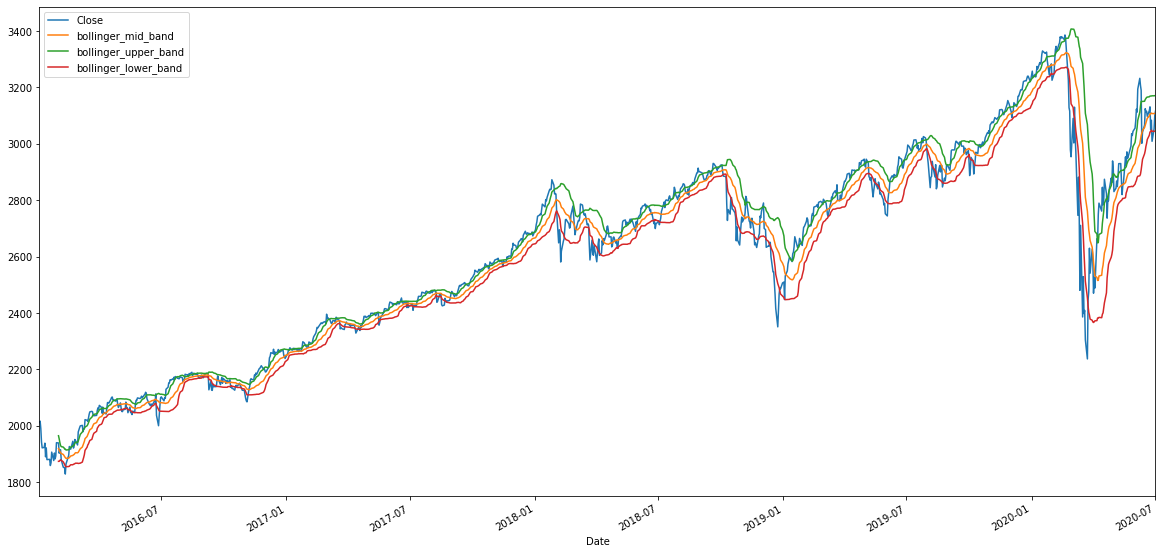

In [10]:
# Plot the Bollinger Bands for BTC/USD closing prices
data[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [11]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']

# Filter by x-variable list
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-06-25,1.0,-1.0,0.0
2020-06-26,-1.0,-1.0,1.0
2020-06-29,-1.0,-1.0,0.0
2020-06-30,1.0,1.0,0.0
2020-07-01,1.0,1.0,0.0


In [12]:
# Shift DataFrame values by 1
data[x_var_list] = data[x_var_list].shift(1)
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-06-25,1.0,1.0,0.0
2020-06-26,1.0,-1.0,0.0
2020-06-29,-1.0,-1.0,1.0
2020-06-30,-1.0,-1.0,0.0
2020-07-01,1.0,1.0,0.0


In [13]:
# Drop NAs and replace positive/negative infinity values
data.dropna(subset=x_var_list, inplace=True)
data.dropna(subset=['Daily_Return'], inplace=True)
data = data.replace([np.inf, -np.inf], np.nan)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000,0.002012,2015.359985,2014.755149,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000,-0.013115,2001.017142,2006.018067,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000,-0.023700,1970.122648,1988.614595,0.0,...,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4664940000,-0.010838,1945.300651,1973.390722,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-11,1926.119995,1935.650024,1901.099976,1923.670044,1923.670044,4607290000,0.000853,1934.313676,1963.604730,0.0,...,0.0,-1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [14]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
data['Positive Return'] = np.where(data['Daily_Return'] > 0, 1.0, 0.0)
data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,...,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000,0.002012,2015.359985,2014.755149,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000,-0.013115,2001.017142,2006.018067,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000,-0.023700,1970.122648,1988.614595,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4664940000,-0.010838,1945.300651,1973.390722,0.0,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2016-01-11,1926.119995,1935.650024,1901.099976,1923.670044,1923.670044,4607290000,0.000853,1934.313676,1963.604730,0.0,...,-1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,3046.600098,3086.250000,3024.010010,3083.760010,3083.760010,4815420000,0.010959,3084.736870,3053.172709,1.0,...,-1.0,1.0,3109.213525,60.514460,3169.727985,3048.699065,0.0,0.0,0.0,1.0
2020-06-26,3073.199951,3073.729980,3004.629883,3009.050049,3009.050049,8098120000,-0.024227,3046.893459,3050.217946,0.0,...,-1.0,-1.0,3107.450525,62.968704,3170.419229,3044.481821,1.0,0.0,0.0,0.0
2020-06-29,3018.590088,3053.889893,2999.739990,3053.239990,3053.239990,4462770000,0.014686,3050.066725,3050.420324,0.0,...,-1.0,-1.0,3107.326025,63.078712,3170.404737,3044.247314,0.0,0.0,1.0,1.0


In [15]:
# Construct training start and end dates
training_start = data.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-04-30'

# Construct testing start and end dates
testing_start =  '2020-05-01'
testing_end = data.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2016-01-05
Training End: 2020-04-30
Testing Start: 2020-05-01
Testing End: 2020-07-01


In [16]:
# Construct the X_train and y_train datasets
X_train = data[x_var_list][training_start:training_end]
y_train = data['Positive Return'][training_start:training_end]

X_train.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-04-24,1.0,1.0,0.0
2020-04-27,1.0,1.0,-1.0
2020-04-28,1.0,1.0,-1.0
2020-04-29,1.0,1.0,0.0
2020-04-30,1.0,1.0,-1.0


In [17]:
y_train.tail()

Date
2020-04-24    1.0
2020-04-27    1.0
2020-04-28    0.0
2020-04-29    1.0
2020-04-30    0.0
Name: Positive Return, dtype: float64

In [18]:
# Construct the X test and y test datasets
X_test = data[x_var_list][testing_start:testing_end]
y_test = data['Positive Return'][testing_start:testing_end]

X_test.head()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-05-01,1.0,1.0,-1.0
2020-05-04,1.0,1.0,0.0
2020-05-05,1.0,1.0,0.0
2020-05-06,1.0,1.0,0.0
2020-05-07,1.0,1.0,0.0


In [19]:
y_test.tail()

Date
2020-06-25    1.0
2020-06-26    0.0
2020-06-29    1.0
2020-06-30    1.0
2020-07-01    1.0
Name: Positive Return, dtype: float64

In [20]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
Date,,
2020-05-01,0.0,1.0
2020-05-04,1.0,1.0
2020-05-05,1.0,1.0
2020-05-06,0.0,1.0
2020-05-07,1.0,1.0
2020-05-08,1.0,1.0
2020-05-11,1.0,1.0
2020-05-12,0.0,1.0
2020-05-13,0.0,1.0


In [21]:
# make the predictions from the X_test dataset
predictions = model.predict(X_test)
predictions

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1.])

In [22]:
# Y test data predicted
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
Date,,
2020-05-01,0.0,1.0
2020-05-04,1.0,1.0
2020-05-05,1.0,1.0
2020-05-06,0.0,1.0
2020-05-07,1.0,1.0
2020-05-08,1.0,1.0
2020-05-11,1.0,1.0
2020-05-12,0.0,1.0
2020-05-13,0.0,1.0


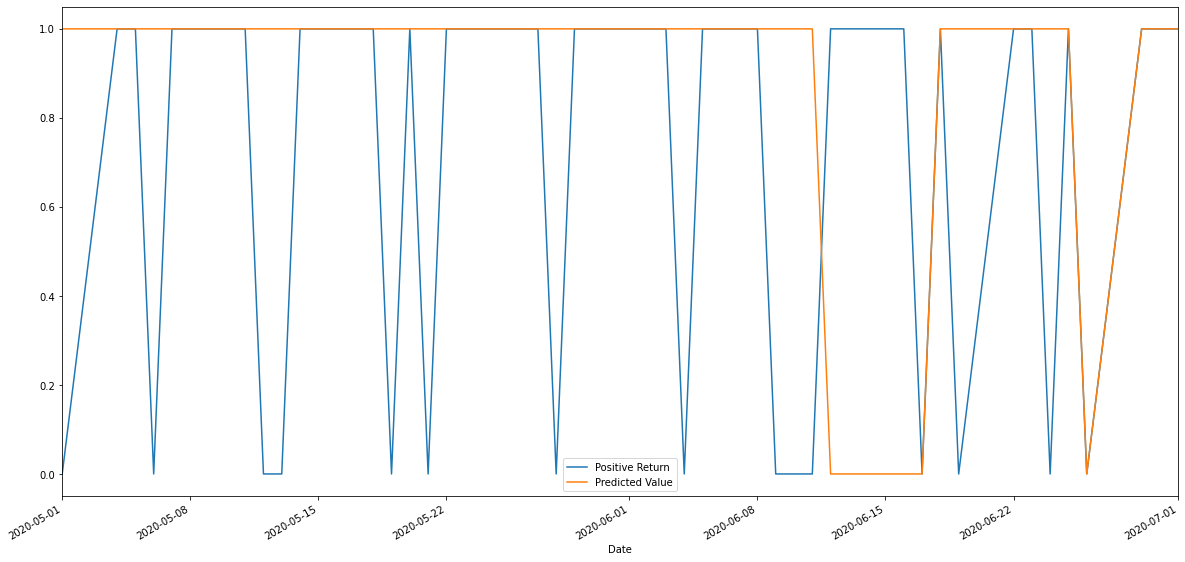

In [23]:
# Plot predicted results vs. actual results
Results[['Positive Return', 'Predicted Value']].plot(figsize=(20,10))

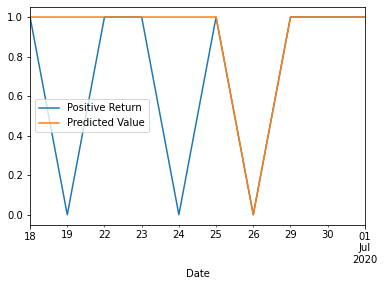

In [24]:
Results[['Positive Return', 'Predicted Value']].tail(10).plot()

In [25]:
Results['Predicted Value'].replace(0, -1, inplace=True)
Results

,Positive Return,Predicted Value
Date,,
2020-05-01,0.0,1.0
2020-05-04,1.0,1.0
2020-05-05,1.0,1.0
2020-05-06,0.0,1.0
2020-05-07,1.0,1.0
2020-05-08,1.0,1.0
2020-05-11,1.0,1.0
2020-05-12,0.0,1.0
2020-05-13,0.0,1.0


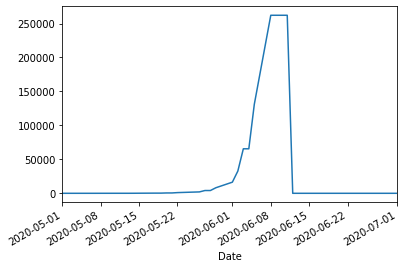

In [26]:
(1 + (Results['Positive Return'] * Results['Predicted Value'])).cumprod().plot()

In [27]:
# Calculating the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)



In [28]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,2,13
Actual 1,3,25


Accuracy Score : 0.627906976744186
Classification Report
              precision    recall  f1-score   support

         0.0       0.40      0.13      0.20        15
         1.0       0.66      0.89      0.76        28

    accuracy                           0.63        43
   macro avg       0.53      0.51      0.48        43
weighted avg       0.57      0.63      0.56        43



---

## Gold Price

In [29]:
tickers = ['GC=F']

data = yf.download(tickers, '2016-01-01')
data.fillna(method='ffill', inplace=True)
data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-26,1770.500000,1786.199951,1754.000000,1784.800049,1784.800049,92443954
2020-06-28,1789.199951,1790.400024,1785.000000,1785.300049,1785.300049,500645
2020-06-29,1785.400024,1789.400024,1776.500000,1784.699951,1784.699951,75763985
2020-06-30,1782.800049,1804.000000,1774.800049,1800.400024,1800.400024,87426446
2020-07-01,1802.000000,1807.699951,1767.900024,1778.900024,1778.900024,128602190


In [30]:
data['Daily_Return'] = data['Close'].dropna().pct_change()
data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return
Date,,,,,,,
2016-01-04,1063.400024,1082.500000,1063.199951,1075.099976,1075.099976,10,NaN
2016-01-05,1075.599976,1081.500000,1075.300049,1078.400024,1078.400024,143,0.003070
2016-01-06,1081.599976,1093.699951,1081.599976,1091.900024,1091.900024,82,0.012519
2016-01-07,1091.599976,1109.400024,1091.599976,1107.699951,1107.699951,52,0.014470
2016-01-08,1111.099976,1111.099976,1093.000000,1097.800049,1097.800049,122,-0.008937
...,...,...,...,...,...,...,...
2020-06-26,1770.500000,1786.199951,1754.000000,1784.800049,1784.800049,92443954,0.005012
2020-06-28,1789.199951,1790.400024,1785.000000,1785.300049,1785.300049,500645,0.000280
2020-06-29,1785.400024,1789.400024,1776.500000,1784.699951,1784.699951,75763985,-0.000336


In [31]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_close'] = data['Close'].ewm(halflife=short_window).mean()
data['slow_close'] = data['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
data['crossover_long'] = np.where(data['fast_close'] > data['slow_close'], 1.0, 0.0)
data['crossover_short'] = np.where(data['fast_close'] < data['slow_close'], -1.0, 0.0)
data['crossover_signal'] = data['crossover_long'] + data['crossover_short']

data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,,,,,,
2016-01-04,1063.400024,1082.500000,1063.199951,1075.099976,1075.099976,10,NaN,1075.099976,1075.099976,0.0,0.0,0.0
2016-01-05,1075.599976,1081.500000,1075.300049,1078.400024,1078.400024,143,0.003070,1077.300008,1076.807163,1.0,0.0,1.0
2016-01-06,1081.599976,1093.699951,1081.599976,1091.900024,1091.900024,82,0.012519,1085.642875,1082.190580,1.0,0.0,1.0
2016-01-07,1091.599976,1109.400024,1091.599976,1107.699951,1107.699951,52,0.014470,1097.406649,1089.245483,1.0,0.0,1.0
2016-01-08,1111.099976,1111.099976,1093.000000,1097.800049,1097.800049,122,-0.008937,1097.609694,1091.201396,1.0,0.0,1.0


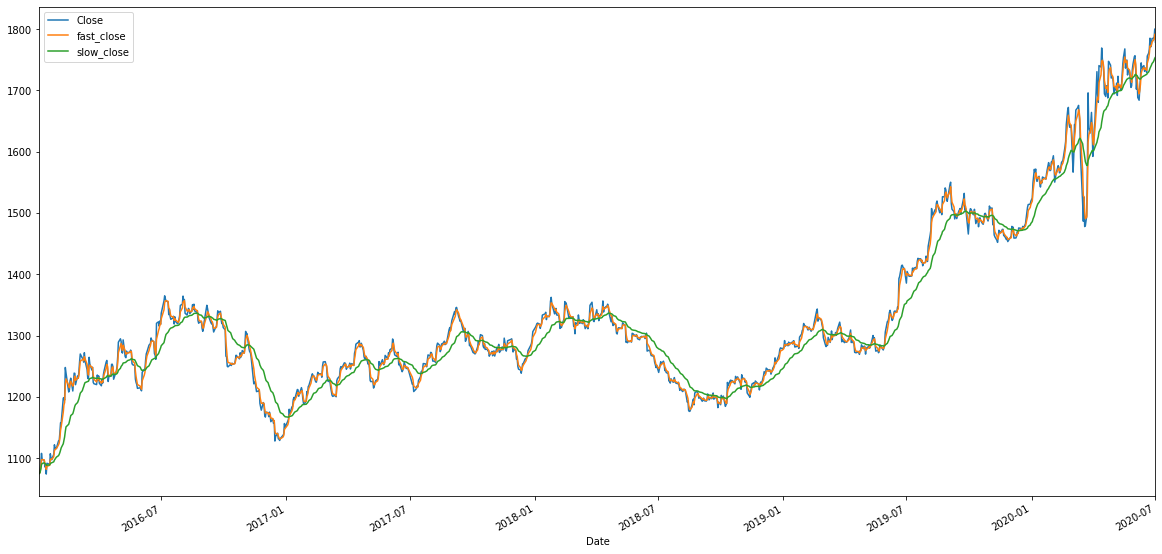

In [32]:
# Plot the EMA of BTC/USD closing prices
data[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [33]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_vol'] = data['Daily_Return'].ewm(halflife=short_vol_window).std()
data['slow_vol'] = data['Daily_Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
data['vol_trend_long'] = np.where(data['fast_vol'] < data['slow_vol'], 1.0, 0.0)
data['vol_trend_short'] = np.where(data['fast_vol'] > data['slow_vol'], -1.0, 0.0) 
data['vol_trend_signal'] = data['vol_trend_long'] + data['vol_trend_short']

data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,,,,,,
2016-01-04,1063.400024,1082.500000,1063.199951,1075.099976,1075.099976,10,NaN,1075.099976,1075.099976,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2016-01-05,1075.599976,1081.500000,1075.300049,1078.400024,1078.400024,143,0.003070,1077.300008,1076.807163,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0
2016-01-06,1081.599976,1093.699951,1081.599976,1091.900024,1091.900024,82,0.012519,1085.642875,1082.190580,1.0,0.0,1.0,0.006681,0.006681,0.0,0.0,0.0
2016-01-07,1091.599976,1109.400024,1091.599976,1107.699951,1107.699951,52,0.014470,1097.406649,1089.245483,1.0,0.0,1.0,0.005102,0.006014,1.0,0.0,1.0
2016-01-08,1111.099976,1111.099976,1093.000000,1097.800049,1097.800049,122,-0.008937,1097.609694,1091.201396,1.0,0.0,1.0,0.013831,0.011045,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,1770.500000,1786.199951,1754.000000,1784.800049,1784.800049,92443954,0.005012,1779.336457,1744.036871,1.0,0.0,1.0,0.005752,0.008937,1.0,0.0,1.0
2020-06-28,1789.199951,1790.400024,1785.000000,1785.300049,1785.300049,500645,0.000280,1782.318253,1746.800143,1.0,0.0,1.0,0.004416,0.008640,1.0,0.0,1.0
2020-06-29,1785.400024,1789.400024,1776.500000,1784.699951,1784.699951,75763985,-0.000336,1783.509102,1749.338180,1.0,0.0,1.0,0.003359,0.008360,1.0,0.0,1.0


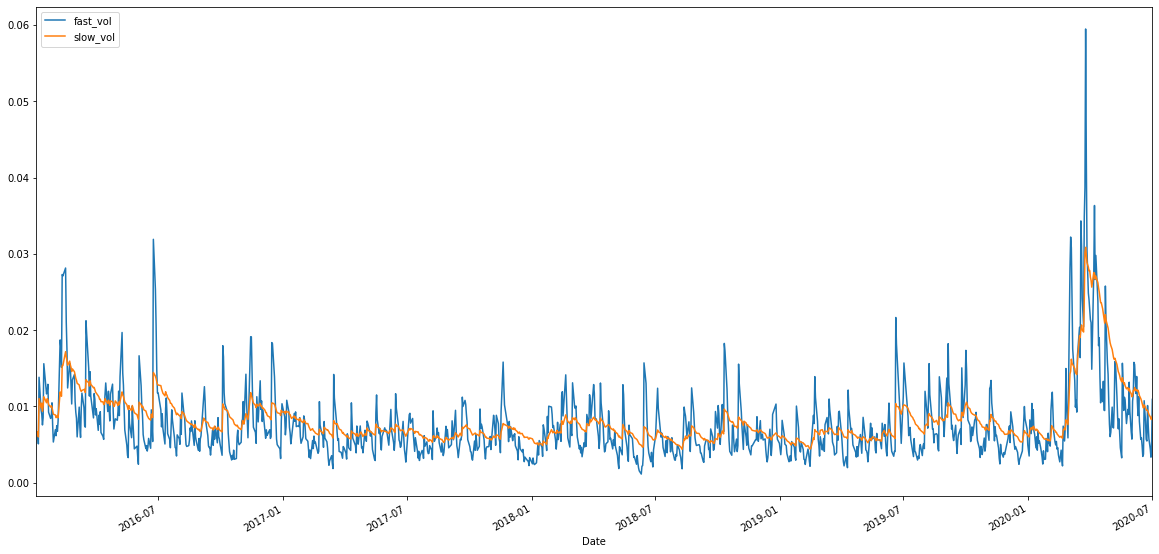

In [34]:
# Plot the EMA of BTC/USD daily return volatility
data[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

In [35]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
data['bollinger_mid_band'] = data['Close'].rolling(window=bollinger_window).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
data['bollinger_upper_band']  = data['bollinger_mid_band'] + (data['bollinger_std'] * 1)
data['bollinger_lower_band']  = data['bollinger_mid_band'] - (data['bollinger_std'] * 1)

# Calculate bollinger band trading signal
data['bollinger_long'] = np.where(data['Close'] < data['bollinger_lower_band'], 1.0, 0.0)
data['bollinger_short'] = np.where(data['Close'] > data['bollinger_upper_band'], -1.0, 0.0)
data['bollinger_signal'] = data['bollinger_long'] + data['bollinger_short']

data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,1063.400024,1082.500000,1063.199951,1075.099976,1075.099976,10,NaN,1075.099976,1075.099976,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-05,1075.599976,1081.500000,1075.300049,1078.400024,1078.400024,143,0.003070,1077.300008,1076.807163,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-06,1081.599976,1093.699951,1081.599976,1091.900024,1091.900024,82,0.012519,1085.642875,1082.190580,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-07,1091.599976,1109.400024,1091.599976,1107.699951,1107.699951,52,0.014470,1097.406649,1089.245483,1.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-08,1111.099976,1111.099976,1093.000000,1097.800049,1097.800049,122,-0.008937,1097.609694,1091.201396,1.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,1770.500000,1786.199951,1754.000000,1784.800049,1784.800049,92443954,0.005012,1779.336457,1744.036871,1.0,...,1.0,0.0,1.0,1740.620013,28.815586,1769.435600,1711.804427,0.0,-1.0,-1.0
2020-06-28,1789.199951,1790.400024,1785.000000,1785.300049,1785.300049,500645,0.000280,1782.318253,1746.800143,1.0,...,1.0,0.0,1.0,1743.895013,30.021698,1773.916711,1713.873315,0.0,-1.0,-1.0
2020-06-29,1785.400024,1789.400024,1776.500000,1784.699951,1784.699951,75763985,-0.000336,1783.509102,1749.338180,1.0,...,1.0,0.0,1.0,1748.700012,28.349776,1777.049788,1720.350236,0.0,-1.0,-1.0


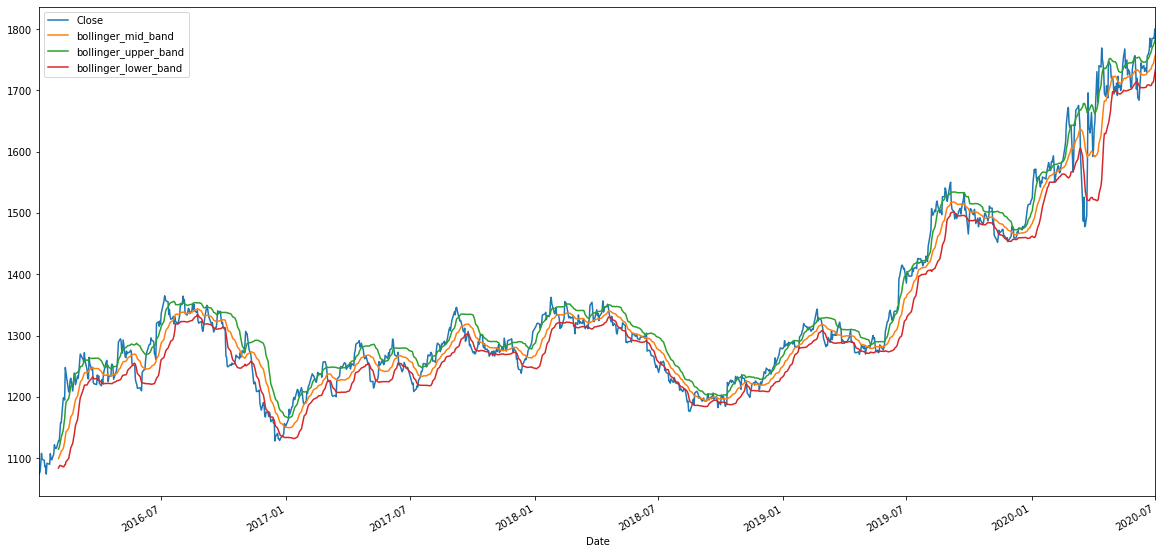

In [36]:
# Plot the Bollinger Bands for BTC/USD closing prices
data[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [37]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']

# Filter by x-variable list
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-06-26,1.0,1.0,-1.0
2020-06-28,1.0,1.0,-1.0
2020-06-29,1.0,1.0,-1.0
2020-06-30,1.0,1.0,-1.0
2020-07-01,1.0,-1.0,0.0


In [38]:
# Shift DataFrame values by 1
data[x_var_list] = data[x_var_list].shift(1)
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-06-26,1.0,1.0,-1.0
2020-06-28,1.0,1.0,-1.0
2020-06-29,1.0,1.0,-1.0
2020-06-30,1.0,1.0,-1.0
2020-07-01,1.0,1.0,-1.0


In [39]:
# Drop NAs and replace positive/negative infinity values
data.dropna(subset=x_var_list, inplace=True)
data.dropna(subset=['Daily_Return'], inplace=True)
data = data.replace([np.inf, -np.inf], np.nan)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,1075.599976,1081.500000,1075.300049,1078.400024,1078.400024,143,0.003070,1077.300008,1076.807163,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-06,1081.599976,1093.699951,1081.599976,1091.900024,1091.900024,82,0.012519,1085.642875,1082.190580,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-07,1091.599976,1109.400024,1091.599976,1107.699951,1107.699951,52,0.014470,1097.406649,1089.245483,1.0,...,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-08,1111.099976,1111.099976,1093.000000,1097.800049,1097.800049,122,-0.008937,1097.609694,1091.201396,1.0,...,0.0,-1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-11,1105.699951,1107.900024,1096.500000,1096.500000,1096.500000,98,-0.001184,1097.046040,1092.244264,1.0,...,1.0,0.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [40]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
data['Positive Return'] = np.where(data['Daily_Return'] > 0, 1.0, 0.0)
data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,...,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,1075.599976,1081.500000,1075.300049,1078.400024,1078.400024,143,0.003070,1077.300008,1076.807163,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2016-01-06,1081.599976,1093.699951,1081.599976,1091.900024,1091.900024,82,0.012519,1085.642875,1082.190580,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2016-01-07,1091.599976,1109.400024,1091.599976,1107.699951,1107.699951,52,0.014470,1097.406649,1089.245483,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2016-01-08,1111.099976,1111.099976,1093.000000,1097.800049,1097.800049,122,-0.008937,1097.609694,1091.201396,1.0,...,-1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2016-01-11,1105.699951,1107.900024,1096.500000,1096.500000,1096.500000,98,-0.001184,1097.046040,1092.244264,1.0,...,0.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,1770.500000,1786.199951,1754.000000,1784.800049,1784.800049,92443954,0.005012,1779.336457,1744.036871,1.0,...,0.0,1.0,1740.620013,28.815586,1769.435600,1711.804427,0.0,-1.0,-1.0,1.0
2020-06-28,1789.199951,1790.400024,1785.000000,1785.300049,1785.300049,500645,0.000280,1782.318253,1746.800143,1.0,...,0.0,1.0,1743.895013,30.021698,1773.916711,1713.873315,0.0,-1.0,-1.0,1.0
2020-06-29,1785.400024,1789.400024,1776.500000,1784.699951,1784.699951,75763985,-0.000336,1783.509102,1749.338180,1.0,...,0.0,1.0,1748.700012,28.349776,1777.049788,1720.350236,0.0,-1.0,-1.0,0.0


In [41]:
# Construct training start and end dates
training_start = data.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-04-30'

# Construct testing start and end dates
testing_start =  '2020-05-01'
testing_end = data.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2016-01-05
Training End: 2020-04-30
Testing Start: 2020-05-01
Testing End: 2020-07-01


In [42]:
# Construct the X_train and y_train datasets
X_train = data[x_var_list][training_start:training_end]
y_train = data['Positive Return'][training_start:training_end]

X_train.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-04-26,1.0,1.0,0.0
2020-04-27,1.0,1.0,0.0
2020-04-28,1.0,1.0,0.0
2020-04-29,1.0,1.0,0.0
2020-04-30,1.0,1.0,0.0


In [43]:
y_train.tail()

Date
2020-04-26    0.0
2020-04-27    0.0
2020-04-28    1.0
2020-04-29    1.0
2020-04-30    0.0
Name: Positive Return, dtype: float64

In [44]:
# Construct the X test and y test datasets
X_test = data[x_var_list][testing_start:testing_end]
y_test = data['Positive Return'][testing_start:testing_end]

X_test.head()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-05-01,1.0,1.0,0.0
2020-05-03,1.0,1.0,1.0
2020-05-04,1.0,1.0,0.0
2020-05-05,1.0,1.0,0.0
2020-05-06,1.0,1.0,0.0


In [45]:
y_test.tail()

Date
2020-06-26    1.0
2020-06-28    1.0
2020-06-29    0.0
2020-06-30    1.0
2020-07-01    0.0
Name: Positive Return, dtype: float64

In [46]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
Date,,
2020-05-01,0.0,1.0
2020-05-03,1.0,0.0
2020-05-04,0.0,1.0
2020-05-05,1.0,1.0
2020-05-06,0.0,1.0
2020-05-07,1.0,0.0
2020-05-08,0.0,1.0
2020-05-10,1.0,1.0
2020-05-11,0.0,1.0


In [47]:
# make the predictions from the X_test dataset
predictions = model.predict(X_test)
predictions

array([1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0.])

In [48]:
# Y test data predicted
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
Date,,
2020-05-01,0.0,1.0
2020-05-03,1.0,0.0
2020-05-04,0.0,1.0
2020-05-05,1.0,1.0
2020-05-06,0.0,1.0
2020-05-07,1.0,0.0
2020-05-08,0.0,1.0
2020-05-10,1.0,1.0
2020-05-11,0.0,1.0


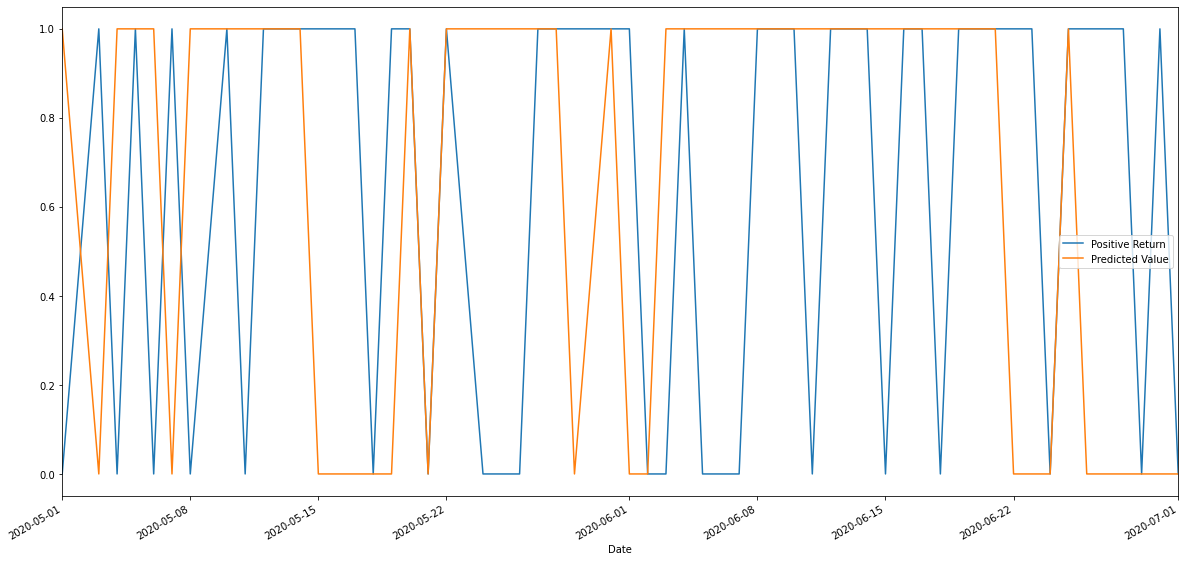

In [49]:
# Plot predicted results vs. actual results
Results[['Positive Return', 'Predicted Value']].plot(figsize=(20,10))

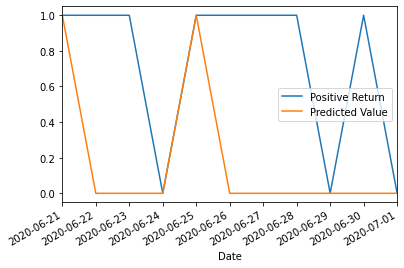

In [50]:
Results[['Positive Return', 'Predicted Value']].tail(10).plot()

In [51]:
Results['Predicted Value'].replace(0, -1, inplace=True)
Results

,Positive Return,Predicted Value
Date,,
2020-05-01,0.0,1.0
2020-05-03,1.0,-1.0
2020-05-04,0.0,1.0
2020-05-05,1.0,1.0
2020-05-06,0.0,1.0
2020-05-07,1.0,-1.0
2020-05-08,0.0,1.0
2020-05-10,1.0,1.0
2020-05-11,0.0,1.0


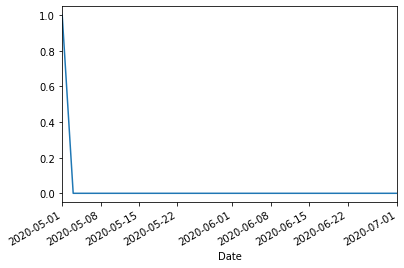

In [52]:
(1 + (Results['Positive Return'] * Results['Predicted Value'])).cumprod().plot()

In [53]:
# Calculating the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [54]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,6,13
Actual 1,12,21


Accuracy Score : 0.5192307692307693
Classification Report
              precision    recall  f1-score   support

         0.0       0.33      0.32      0.32        19
         1.0       0.62      0.64      0.63        33

    accuracy                           0.52        52
   macro avg       0.48      0.48      0.48        52
weighted avg       0.51      0.52      0.52        52

